In [471]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import skimage
import torch

from defocus import Microscope

In [472]:
# knowns
WAVELENGTH = 405e-9
R_INDEX = 1
BEAM_WAIST = 200e-9
NA = 0.95
MAGNIFICATION = 1
PIXEL_SIZE = 200e-9

KERNEL_SIZE = 64

IMAGE_SIZE = 100
NOISE = 0.05
EMITTER_DENSITY = 0.001

In [473]:
# laser PSF

def gaussian_beam(r, z):
    z_r = np.pi * (BEAM_WAIST ** 2) * R_INDEX / WAVELENGTH
    w = BEAM_WAIST * np.sqrt(1 + (z / z_r) ** 2)
    return (BEAM_WAIST / w) * np.exp(-(r ** 2) / (w ** 2))


def laser_psf(defocus: float):
    psf = np.zeros((KERNEL_SIZE, KERNEL_SIZE))
    for i in range(KERNEL_SIZE):
        for j in range(KERNEL_SIZE):
            x = i - (KERNEL_SIZE - 1) / 2
            y = j - (KERNEL_SIZE - 1) / 2
            r = np.sqrt(x ** 2 + y ** 2)
            psf[j, i] = gaussian_beam(r * PIXEL_SIZE, defocus)
    return psf

In [474]:
# microscope PSF

def microscope_psf(defocus: float):
    scope = Microscope(dim=KERNEL_SIZE * 4, NA=NA, mag=MAGNIFICATION, wavelength=WAVELENGTH, pixel_size=PIXEL_SIZE, device=torch.device('cpu'))
    a = int(KERNEL_SIZE * 1.5)
    return np.array(scope.get_psf(defocus))[a:a+KERNEL_SIZE, a:a+KERNEL_SIZE]

/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_62137/562086098.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(scope.get_psf(defocus))[a:a+KERNEL_SIZE, a:a+KERNEL_SIZE]


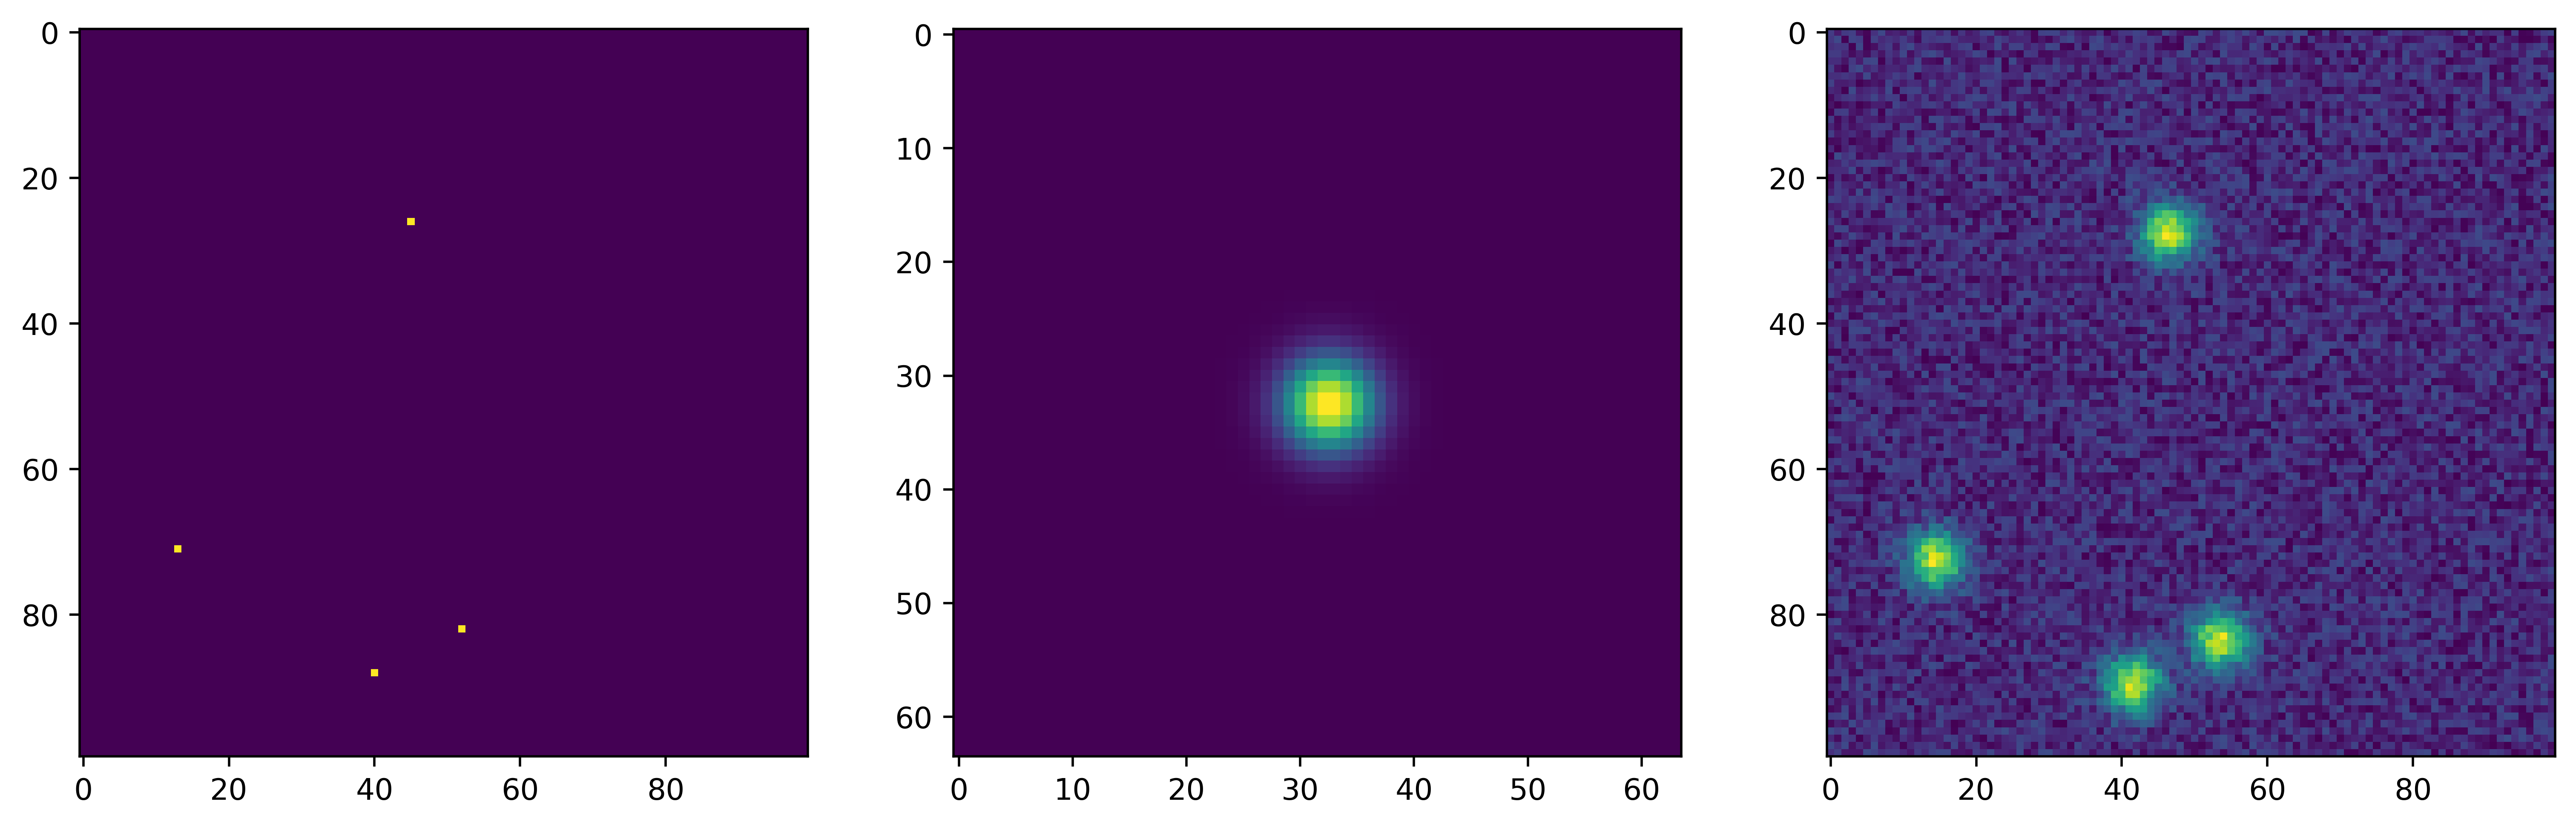

In [475]:
# generate ground truth image, "captured image"

np.random.seed(1)

defocus = 2 * WAVELENGTH


image = np.random.choice([0, 1], size=(IMAGE_SIZE, IMAGE_SIZE), p=[1 - EMITTER_DENSITY, EMITTER_DENSITY])
psf = scp.signal.convolve2d(microscope_psf(defocus), laser_psf(defocus), mode="same")

captured_image = scp.signal.convolve2d(image, psf, mode="same") + NOISE * np.random.uniform(0, 1, size=(IMAGE_SIZE, IMAGE_SIZE))

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(psf)
plt.subplot(1,3,3)
plt.imshow(captured_image)

/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_62137/562086098.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(scope.get_psf(defocus))[a:a+KERNEL_SIZE, a:a+KERNEL_SIZE]


ITERATION 0
Current Defocus: 4.05e-07, Last Defocus: 0, delta: 4.05e-07
Current Score: 55, Last Score: 71, delta: -16
Alpha: 2e-15, Defocus Adjust: 7.901234567901236e-08
ITERATION 1
Current Defocus: 4.840123456790124e-07, Last Defocus: 4.05e-07, delta: 7.901234567901237e-08
Current Score: 52, Last Score: 55, delta: -3
Alpha: 1.9933333333333335e-15, Defocus Adjust: 5.9061728395061734e-08
ITERATION 2
Current Defocus: 5.430740740740741e-07, Last Defocus: 4.840123456790124e-07, delta: 5.906172839506175e-08
Current Score: 42, Last Score: 52, delta: -10
Alpha: 1.986666666666667e-15, Defocus Adjust: 1.9621399176954736e-07
ITERATION 3
Current Defocus: 7.392880658436215e-07, Last Defocus: 5.430740740740741e-07, delta: 1.9621399176954739e-07
Current Score: 43, Last Score: 42, delta: 1
Alpha: 1.9800000000000002e-15, Defocus Adjust: -1.0091023489932884e-08
ITERATION 4
Current Defocus: 7.291970423536886e-07, Last Defocus: 7.392880658436215e-07, delta: -1.009102348993292e-08
Current Score: 42, Last 

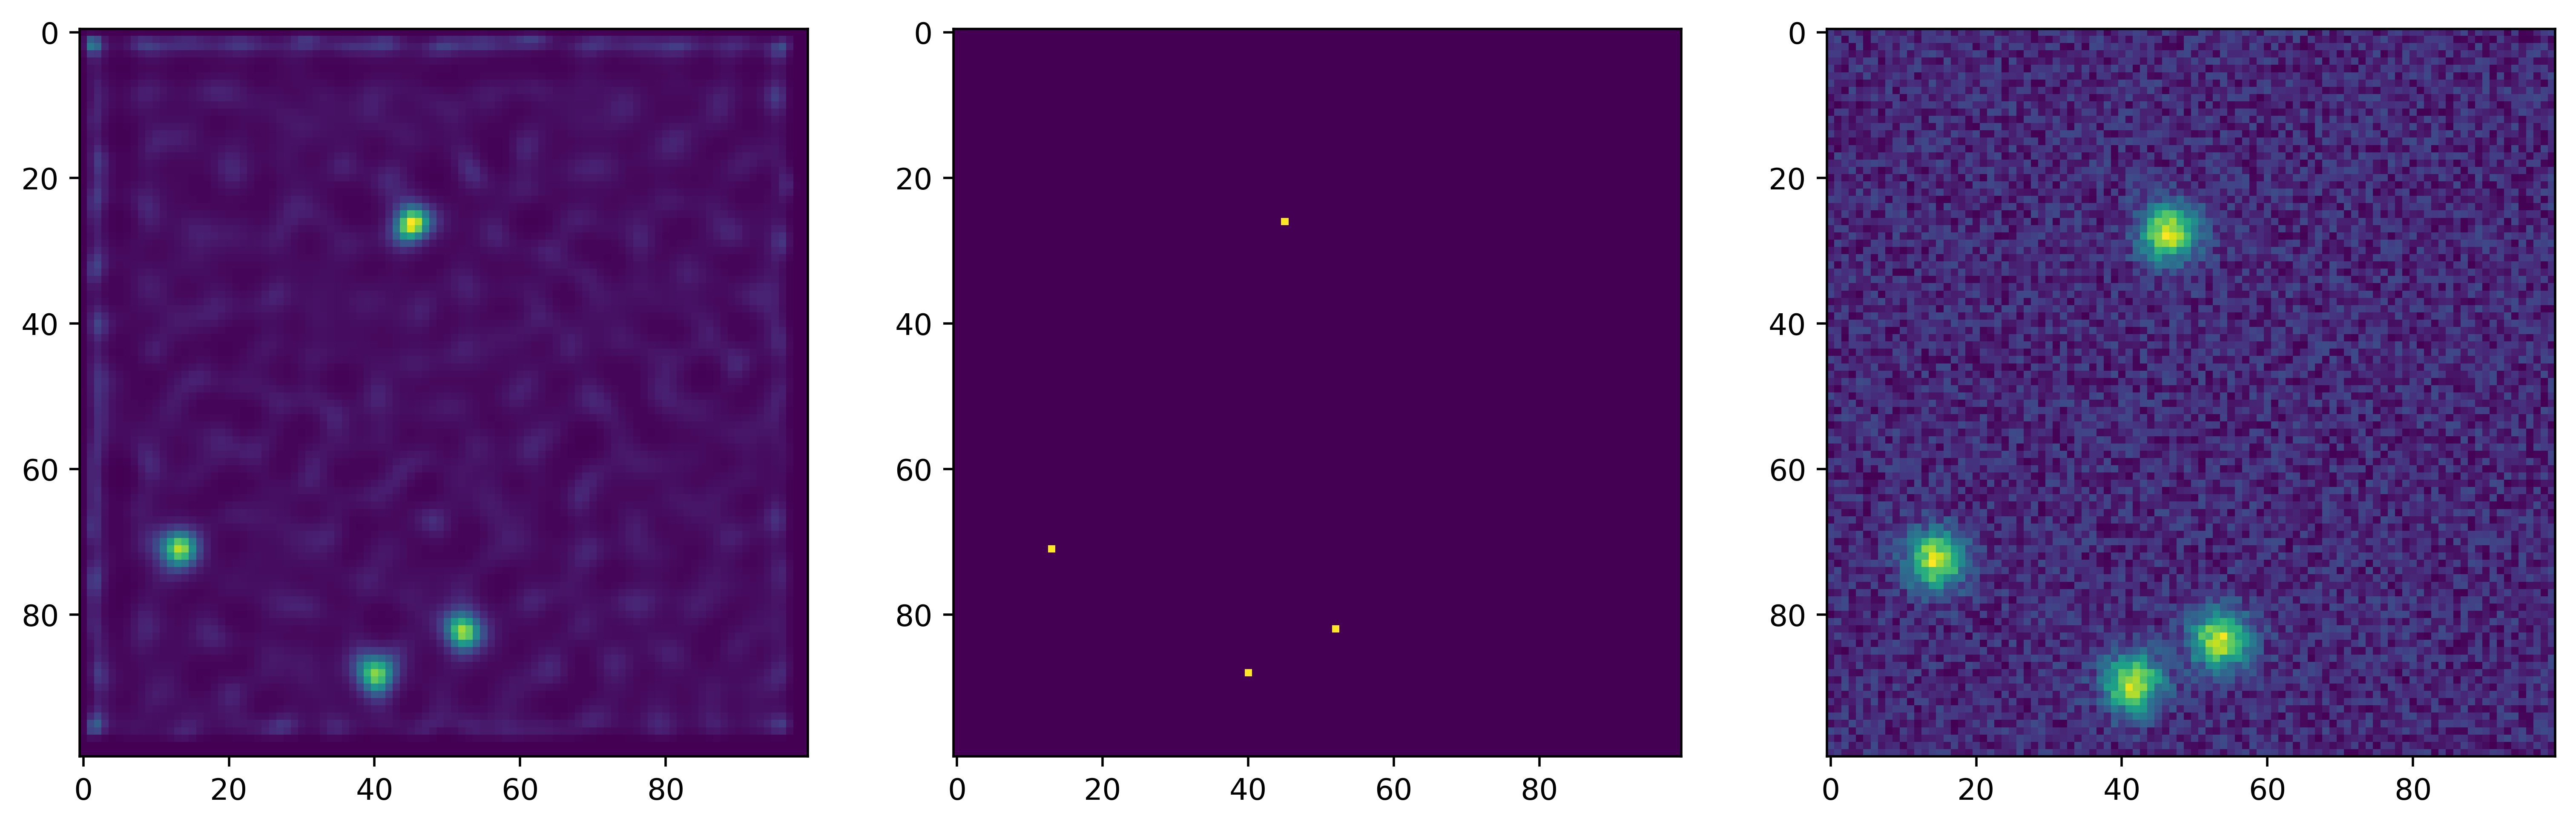

In [476]:
### --- PRETEND WE DONT KNOW ANYTHING --- ###
DECONV_ITERATIONS = 30
DEFOCUS_ITERATIONS = 30
ALPHA = 2e-15
BETA = 0.1

def try_deconvolve(image, defocus, iterations):
    psf = scp.signal.convolve2d(microscope_psf(defocus), laser_psf(defocus), mode="same")
    return skimage.restoration.richardson_lucy(image, psf, iterations)

def score(image):
    count = 0
    for i in image:
        for j in i:
            if j > np.max(image) * 0.5:
                count += 1
    return count

last_defocus = 0
current_defocus = WAVELENGTH
last_score = score(try_deconvolve(captured_image, last_defocus, DECONV_ITERATIONS))
current_score = score(try_deconvolve(captured_image, current_defocus, DECONV_ITERATIONS))

for i in range(DEFOCUS_ITERATIONS):
    print(f"ITERATION {i}")

    defocus_diff = current_defocus - last_defocus
    print(f"Current Defocus: {current_defocus}, Last Defocus: {last_defocus}, delta: {defocus_diff}")
    if (np.abs(defocus_diff) < WAVELENGTH * 0.25):
        if defocus_diff <= 0:
            defocus_diff = -WAVELENGTH * 0.25
        else:
            defocus_diff = WAVELENGTH * 0.25

    score_diff = current_score - last_score
    print(f"Current Score: {current_score}, Last Score: {last_score}, delta: {score_diff}")
    score_diff = 1 if score_diff == 0 else score_diff

    last_defocus = current_defocus
    a = (ALPHA - ALPHA * BETA / DEFOCUS_ITERATIONS * i)
    diff = -a * score_diff / defocus_diff
    print(f"Alpha: {a}, Defocus Adjust: {diff}")
    current_defocus += diff

    last_score = current_score
    img = try_deconvolve(captured_image, current_defocus, DECONV_ITERATIONS)
    current_score = score(img)

print("FINAL")
print(f"Defocus: {current_defocus}, Score: {current_score}")
recovered_image = try_deconvolve(captured_image, current_defocus, DECONV_ITERATIONS)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(recovered_image)
plt.subplot(1,3,2)
plt.imshow(image)
plt.subplot(1,3,3)
plt.imshow(captured_image)